In [24]:
from __future__ import annotations
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import mlab
from astropy.io import fits
import pandas as pd
from dataclasses import dataclass

import os
import json
from glob import glob

# from uncertainties import unumpy as unp
# from uncertainties import ufloat, umath, Variable

from options import *
from constants import *

# nom_vals = unp.nominal_values
# std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [25]:
@dataclass
class Spec:
    freq: np.ndarray
    data: np.ndarray
    vel: np.ndarray
    params: dict
    possible_relative_velocities: np.ndarray | None = None
    possible_radii: np.ndarray | None = None

In [26]:
def load(dataset: str):
    hdulist = fits.open(dataset)
    hdr = hdulist[0].header
    params = {}

    # spec.fileName = fname;
    # spec.data = fitsread(fname);
    # spec.info = fitsinfo(fname);
    
    # % get the frequency scale from the spec.header of the fits files
    # freq_ref_pix = getKeyword(spec, 'CRPIX1') + 2;
    # freq_delta = getKeyword(spec, 'CDELT1');
    # %disp(2*freq_delta)
    # freq_ref = getKeyword(spec, 'CRVAL1');
    # n_chan = getKeyword(spec, 'NAXIS1');
    # vlsr = getKeyword(spec, 'VELO-LSR')*1000;
            
    # spec.freq = freq_ref + ( (1:n_chan) - freq_ref_pix )*freq_delta;
    # spec.vel = (  -(spec.freq - freq_ref)/freq_ref * ...
    #     spec.c - vlsr) / 1000; % Changed VLSR sign 2015-06-23 to work with SalsaJ
    # spec.index = 1:n_chan;
    # spec.baseSubtracted = 0;
    # spec.gaussiansFitted = 0;

    freq_ref_pix = hdr['CRPIX1'] + 2
    freq_delta = hdr['CDELT1']
    freq_ref = hdr['CRVAL1']
    n_chan = hdr['NAXIS1']
    params['frequency'] = freq_ref

    params['l'] = hdr['CRVAL2']
    params['b'] = hdr['CRVAL3']

    vlsr = hdr['VELO-LSR'] * 1000  # m/s
    params['dt'] = hdr['OBSTIME']

    freq = np.array(freq_ref + (np.arange(1, n_chan+1) - freq_ref_pix) * freq_delta)
    
    bzero = hdr['BZERO']
    bscale = hdr['BSCALE']
    d = hdulist[0].data[0,0,:] * bscale + bzero
    data = to_dB(np.array(d))

    # This is the method we derived
    # vel = -((freq - H21) / freq * sc.constants.c - vlsr) / 1000  # km/s
    
    # This is what Salsa uses
    vel = -((freq - H21) / H21 * sc.constants.c - vlsr) / 1000  # km/s

    spec = Spec(freq, data, vel, params)

    return spec  # :)

In [27]:
data: list[Spec] = []

files = glob("../data/salsa/spectrum_?????.fits")
files.sort()

for file in files:
    spec = load(file)
    data.append(spec)

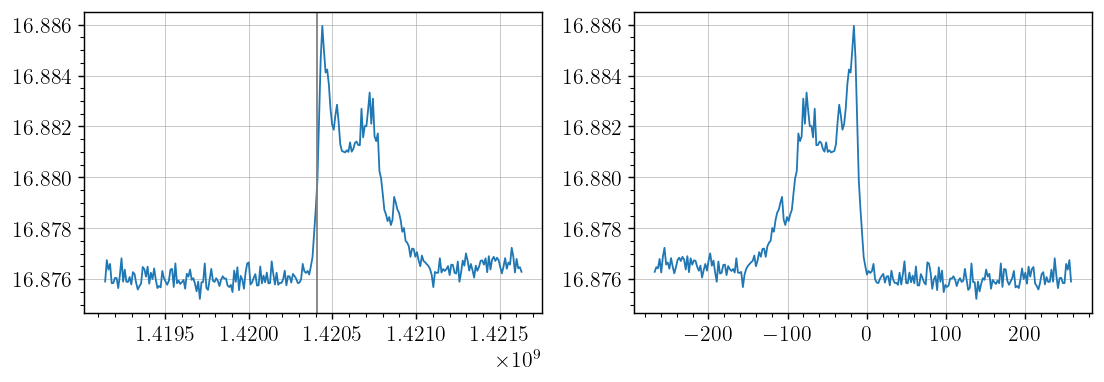

In [28]:
spec = data[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(spec.freq, spec.data)
ax[0].axvline(H21)
ax[1].plot(spec.vel, spec.data)

## Example spectra - comparing preprocessing methods

In [29]:
def clean_up_average(signal: np.ndarray, w: int = 10) -> np.ndarray:
    return np.convolve(signal, np.ones(w), 'same') / w

def clean_up_median(signal: np.ndarray, w: int = 5) -> np.ndarray:
    return sc.signal.medfilt(signal, w)

Using l = 99.8410986861296


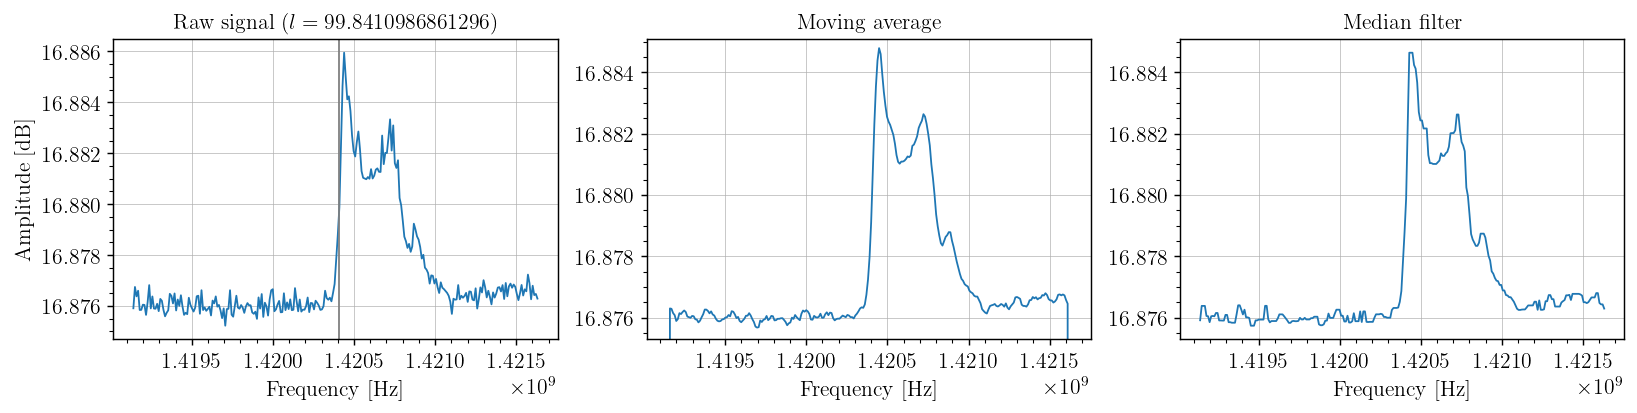

In [30]:
l = spec.params['l']
print("Using l =", l)

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
ax[0].plot(spec.freq, (spec.data))
ax[0].set_title(f"Raw signal ($l={l}$)")
ax[0].axvline(H21)

averaged = clean_up_average(spec.data, w=5)
ax[1].plot(spec.freq, (averaged))
ax[1].set_title("Moving average")

mediand = clean_up_median(spec.data, w=5)
ax[2].plot(spec.freq, (mediand))
ax[2].set_title("Median filter")
ax[1].set_ylim(ax[2].get_ylim())

ax[0].set_ylabel("Amplitude [dB]")
for i in range(3):
    ax[i].set_xlabel("Frequency [Hz]")

So we use moving average

## Sanity check our Dopplering

In [31]:
def calculate_relative_velocity(measured_frequency: float) -> float:
    return sc.constants.c * (H21 - measured_frequency) / measured_frequency  # Checked

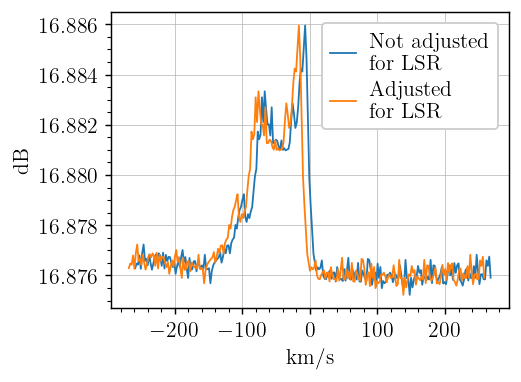

In [32]:
relative_vel_our_method = calculate_relative_velocity(spec.freq) / 1000  # km/s

plt.plot(relative_vel_our_method, (spec.data), label='Not adjusted\nfor LSR')
plt.plot(spec.vel, (spec.data), label='Adjusted\nfor LSR')
plt.xlabel('km/s')
plt.ylabel('dB')
plt.legend()

Our Dopplering could be sane... or I might not be

## Fitting gaussians

In [33]:
def gaussian(x, amplitude, mu, sigma):
    return amplitude * np.exp(-(x - mu)**2 / (2 * sigma**2))

def gaussians(x, offset, *params):
    # assert len(params) % 4 == 0, "At least 4 params per gaussian!"
    return offset + sum(
        gaussian(x, *params[i:i+3]) for i in range(0, len(params), 3)
    )

In [34]:
def do_fits(spectrum, number: int = 3, guesses: list[float] = None):
    if guesses is None:
        mini, maxi = np.min(spec.vel), np.max(spec.vel)
        guesses = np.linspace(mini, maxi, number, endpoint=True)
        # lower_bound = (0, 0, mini, 0.00001) * number
        # upper_bound = (100, 1, maxi, 100) * number
        lower_bound = [0] + [0, mini, 0.00001] * number
        upper_bound = [100] + [1, maxi, 100] * number
    else:
        assert len(guesses) == number
        # lower_bound = [x for xs in ((0, 0, g - 40, 0.00001) for g in guesses) for x in xs]
        # upper_bound = [x for xs in ((100, 1, g + 40, 100) for g in guesses) for x in xs]
        lower_bound = [0] + [x for xs in ((0, g - 40, 0.00001) for g in guesses) for x in xs]
        upper_bound = [100] + [x for xs in ((1, g + 40, 100) for g in guesses) for x in xs]

    # p0 = [x for xs in ((np.min(spectrum.data), 0.0001, g, 10) for g in guesses) for x in xs]
    p0 = [0] + [x for xs in ((0.0001, g, 10) for g in guesses) for x in xs]

    popt, pcov = sc.optimize.curve_fit(
        gaussians,
        spectrum.vel, spectrum.data,
        p0 = p0,
        bounds = (lower_bound, upper_bound),
        check_finite = False
    )
    return popt

In [36]:
all_params = [
    (3, [-110, -70, -20]),          # 0
    (3, [-110, -70, -20]),          # 1
    (3, [-110, -70, -20]),          # 2
    (3, [-110, -70, -20]),          # 3
    (3, [-100, -50, 10]),           # 4
    (3, [-90, -60, 20]),            # 5
    (3, [-60, -30, 20]),            # 6
    (2, [-20, 40]),                 # 7
    (3, [-40, 0, 60]),              # 8
    (2, [10, 60]),                  # 9
    (2, [0, 70]),                   # 10
    (2, [30, 50]),                  # 11
    (1, [50]),                      # 12
    (1, [50]),                      # 13
    (1, [60]),                      # 14
    (3, [-110, -80, -40]),          # 15
    (3, [-120, -80, -40]),          # 16
    (3, [-130, -80, -50]),          # 17
    (2, [-130, -50]),               # 18
    (3, [-130, -70, -40]),          # 19
    (3, [-130, -70, -40]),          # 20
    (3, [-130, -70, -30]),          # 21
    (3, [-130, -70, -20]),          # 22
    (3, [-130, -60, -20]),          # 23
    (4, [-130, -90, -50, 0]),       # 24
    (4, [-130, -80, -50, 0]),       # 25
]
all_params += [(1, None)] * (len(data) - len(all_params))

show_plots = False
for j, (spec, (n, guesses)) in enumerate(zip(data, all_params)):
    popt = do_fits(spec, n, guesses)
    spec.possible_relative_velocities = popt[2::3] * 1000  # m/s

    if show_plots:
        plt.plot(spec.vel, spec.data)
        ylims = plt.ylim()
        plt.plot(spec.vel, gaussians(spec.vel, *popt))
        for i in range(1, len(popt), 3):
            plt.plot(spec.vel, popt[0] + gaussian(spec.vel, *popt[i:i+3]), ls=':', color='C1')
        plt.ylim(ylims)
        plt.title(f"{j=}, l = {spec.params["l"]:.1f}")
        plt.show()

Wow that worked well

## Calculating distance

In [37]:
def bad_distance_estimate(relative_velocity: float, galactic_longitude: float) -> float:
    galactic_rad = deg2rad(galactic_longitude)
    d = relative_velocity / OORT_A.n / np.sin(2 * galactic_rad)
    return abs(d)

In [38]:
def salsa_radius_estimate(relative_velocity: float, galactic_longitude: float) -> float:
    galactic_rad = deg2rad(galactic_longitude)

    if galactic_longitude < 90:
        # Using V_rmax method
        R = R0 * np.sin(galactic_rad) * np.ones_like(relative_velocity)
        # Actually dont. Just use this.
        # R = R0 * V0 * np.sin(galactic_rad) / (V0 * np.sin(galactic_longitude) + relative_velocity)

    elif galactic_rad < 270:
        # Considering V \approx V_0 
        R = R0 * V0 * np.sin(galactic_rad) / (V0 * np.sin(galactic_longitude) + relative_velocity)
    else:
        raise NotImplementedError

    return np.abs(R)

In [39]:
def salsa_distance_estimate(relative_velocity: float, galactic_longitude: float) -> float:
    galactic_rad = deg2rad(galactic_longitude)

    R = salsa_radius_estimate(relative_velocity, galactic_longitude)
    a = np.sqrt(R**2 - R0**2 * np.sin(galactic_rad)**2)
    b = R0 * np.cos(galactic_rad)
    dplus = a + b
    dminus = b - a

    # Only return + solution for now
    return dplus

In [40]:
for spec in data:
    spec.possible_radii = salsa_radius_estimate(spec.possible_relative_velocities, spec.params['l'])

## Velocity curve?????

In [41]:
def velocity_vector_method(relative_velocity: float, galactic_longitude: float) -> float:
    galactic_rad = deg2rad(galactic_longitude)

    d = bad_distance_estimate(relative_velocity, galactic_longitude)
    R = np.sqrt(R0**2 + d**2 - 2 * R0 * d * np.cos(galactic_rad))
    # R = salsa_radius_estimate(relative_velocity, galactic_longitude)

    V_hydrogen_cloud = R / R0 * (relative_velocity / np.sin(galactic_rad) + V0)
    return V_hydrogen_cloud, R

In [42]:
def tangent_method(relative_velocity: float, galactic_longitude: float) -> float:
    galactic_rad = deg2rad(galactic_longitude)
    V_hydrogen = relative_velocity + V0 * np.sin(galactic_rad)
    return V_hydrogen

In [43]:
cloud_velocities_t = []
cloud_velocities_v = []
cloud_orbit_radii_t = []
cloud_orbit_radii_v = []
longitudes_t = []
longitudes_v = []


for spec in data:
    l = spec.params['l']
    if l < 90:
        # for Vr in spec.possible_relative_velocities:
        #     V = tangent_method(Vr, l)
        #     R = salsa_radius_estimate(Vr, l)
        #     cloud_velocities_t.append(V / 1000)
        #     cloud_orbit_radii_t.append(R)
        #     print(V, R)
        # max_relative_velocity_idx = np.argmin(np.abs(spec.possible_relative_velocities))
        max_relative_velocity_idx = np.argsort(np.abs(spec.possible_relative_velocities), axis=0)[-2]
        max_rel_vel = spec.possible_relative_velocities[max_relative_velocity_idx]
        cloud_velocities_t.append(tangent_method(max_rel_vel, l) / 1000)
        cloud_orbit_radii_t.append(salsa_radius_estimate(max_rel_vel, l))
        longitudes_t.append(l)
        # print(spec.possible_relative_velocities)
        # print(spec.possible_radii)
    elif l < 270:
        # print(spec.possible_relative_velocities)
        # for Vr in spec.possible_relative_velocities:
        #     V, R = velocity_vector_method(Vr, l)
        #     cloud_velocities_v.append(V / 1000)
        #     cloud_orbit_radii_v.append(R)
        
        Vs, Rs = velocity_vector_method(spec.possible_relative_velocities, l)
        idx = np.argmin((Vs / 1000)**2 + (Rs / 100)**2)
        cloud_velocities_v.append(Vs[idx] / 1000)
        cloud_orbit_radii_v.append(Rs[idx])
        longitudes_v.append(l)

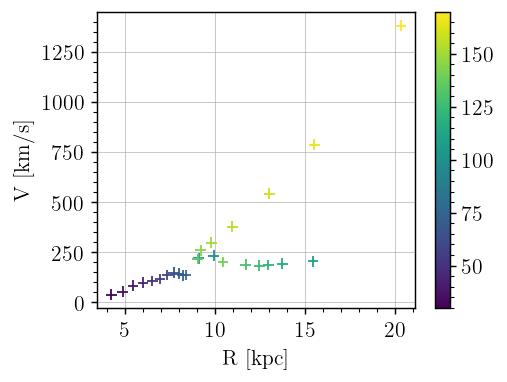

In [44]:
plt.scatter(cloud_orbit_radii_t + cloud_orbit_radii_v, cloud_velocities_t + cloud_velocities_v, c=longitudes_t + longitudes_v)
# plt.scatter(cloud_orbit_radii_v, cloud_velocities_v, c=longitudes_v)
plt.xlabel("R [kpc]")
plt.ylabel("V [km/s]")

# plt.xlim(0, 8.5)
# plt.ylim(0, 400)
plt.colorbar()
plt.savefig("../figures/SALSA_velocity_curve.pdf")

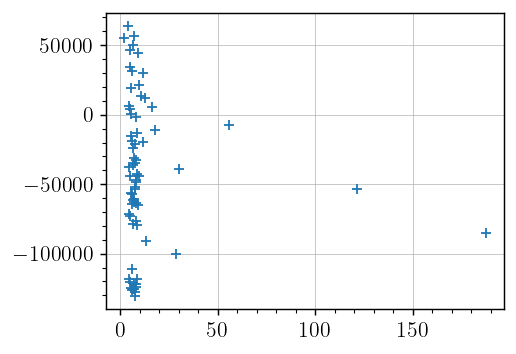

In [45]:
vrs = []
rs = []
for spec in data:
    vrs.extend(spec.possible_relative_velocities)
    rs.extend(spec.possible_radii)

plt.scatter(rs, vrs)

## What are we looking at???

/tmp/ipykernel_26973/3500528083.py:5: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(R**2 - R0**2 * np.sin(galactic_rad)**2)


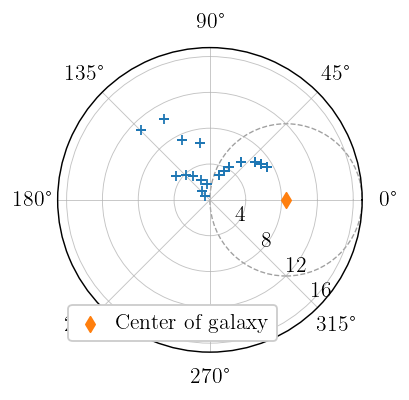

In [23]:
distances = []
angles = []
for spec in data:
    ds = salsa_distance_estimate(spec.possible_relative_velocities, spec.params['l'])
    distances.extend(ds)
    angles.extend((deg2rad(spec.params['l']),) * len(ds))


with mpl.rc_context():
    mpl.rcParams['savefig.bbox'] = 'standard'
    mpl.rcParams["figure.figsize"] = (8*INCH_PER_CM, 7*INCH_PER_CM)
    mpl.rcParams["figure.subplot.left"]   = 0.05
    mpl.rcParams['figure.subplot.right']  = 0.99
    mpl.rcParams['figure.subplot.top']    = 0.97
    mpl.rcParams['figure.subplot.bottom'] = 0.12

    ax = plt.subplot(projection="polar")

    # plt.scatter(longitudes_array, nom_vals(bad_distances))
    plt.scatter(angles, distances)
    # plt.scatter(longitudes_array, less_bad_distances_minus)
    plt.scatter(0, R0, label="Center of galaxy", marker='d')

    circle = plt.Circle((R0, 0), R0, transform=ax.transData._b, facecolor=None, fill=False, ls='--', color="#a0a0a0", zorder=0, lw=0.75)
    ax.add_patch(circle)

    plt.yticks([4,8,12, 16])
    ax.set_rlabel_position(315)
    plt.ylim(0, 17)  # outliers begone

    plt.legend(loc='lower left')
    plt.savefig("../figures/SALSA_galaxy_map.pdf")

